In [1]:
import os 
import torch 
from torch.utils.data import DataLoader, Dataset 
from torchvision.models import resnet18
from torchvision.models import save_image
from torchvision import transforms 
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.optim.lr_scheduler import StepLR 


import shutil 
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# Image processing 
import pandas as pd 
import numpy as np 
from PIL import Image 
import cv2 

# Data visualisation 
import matplotlib.pyplot as plt 

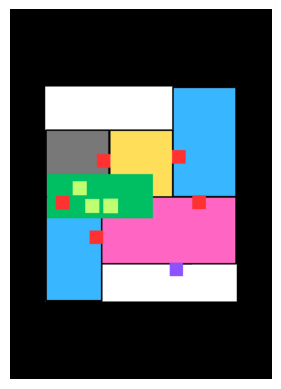

In [2]:
# Function to read images from a folder and store them in a list
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
    return images

# Defining the paths 
train_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\train\input'
train_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\train\target'
val_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\val\input'
val_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\val\target'
test_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input'
test_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\target'

# Load images from each folder
train_input_images = load_images_from_folder(train_input)
train_target_images = load_images_from_folder(train_target)
val_input_images = load_images_from_folder(val_input)
val_target_images = load_images_from_folder(val_target)
test_input_images = load_images_from_folder(test_input)
test_target_images = load_images_from_folder(test_target)

# Display the first image from train_input as an example (convert BGR to RGB for proper display)
if train_input_images:
    plt.imshow(cv2.cvtColor(train_target_images[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No images found in the train input folder.")


In [3]:
# 1. Convert Hex to RGB
def hex_to_rgb(hex_code):
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

colors = {
    'grey': '#787878',
    'yellow': '#FFDE59',
    'blue': '#38b6ff',
    'pink': '#ff66c4',
    'red': '#ff3131',
    'purple': '#8c53ff',
    'green': '#00b563',
    'light_green': '#c1ff72',
    'black': '#000000',
    'white': '#ffffff'
}

rgb_colors = {name: hex_to_rgb(code) for name, code in colors.items()}

# 2. Apply segmentation colors to target images
def apply_segmentation_colors(image_path, color_map):
    image = Image.open(image_path).convert('RGB')
    data = np.array(image)
    for feature, color in color_map.items():
        mask = np.all(data == np.array(color), axis=-1)
        data[mask] = color
    return Image.fromarray(data)

In [5]:
# 3. Update Dataset Class
# Custom Data Loader 
class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(self.input_dir))
        self.target_images = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        # Apply color segmentation
        target_image = apply_segmentation_colors(target_image_path, rgb_colors)

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image
        
# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Load datasets
train_dataset = PairedImageDataset(input_dir=train_input, target_dir=train_target, transform=transform)
val_dataset = PairedImageDataset(input_dir=val_input, target_dir=val_target, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [6]:
# Custom Dataset Class
class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(self.input_dir))
        self.target_images = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = PairedImageDataset(
    input_dir=train_input,
    target_dir=train_target,
    transform=transform
)
val_dataset = PairedImageDataset(
    input_dir=val_input,
    target_dir=val_target,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 8
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [9]:

# Define Encoder with corrected linear layer sizes
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Example input size
        self.example_input = torch.randn(1, 3, 256, 256)
        self._initialize()

    def _initialize(self):
        with torch.no_grad():
            x = self.example_input
            x = self.model(x)  # Forward pass to get output shape
            self.flattened_size = x.view(-1).size(0)
            self.fc_mu = nn.Linear(self.flattened_size, 128)
            self.fc_logvar = nn.Linear(self.flattened_size, 128)

    def forward(self, x):
        x = self.model(x)  # Use self.model for forward pass
        # print("Shape after conv layers:", x.shape)  # Print shape to verify dimensions
        x = x.view(x.size(0), -1)  # Flatten
        # print("Shape after flattening:", x.shape)  # Print shape to verify dimensions
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define Generator and Discriminator classes
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.contracting_block(in_channels, 64)  # [64, 128, 128]
        self.enc2 = self.contracting_block(64, 128)  # [128, 64, 64]
        self.enc3 = self.contracting_block(128, 256)  # [256, 32, 32]
        self.enc4 = self.contracting_block(256, 512)  # [512, 16, 16]

        # Bottleneck
        self.bottleneck = self.contracting_block(512, 1024)  # [1024, 8, 8]

        # Decoder (Upsampling)
        self.dec4 = self.expansive_block(1024, 512)  # [512, 16, 16]
        self.dec3 = self.expansive_block(512, 256)  # [256, 32, 32]
        self.dec2 = self.expansive_block(256, 128)  # [128, 64, 64]
        self.dec1 = self.expansive_block(128, 64)  # [64, 128, 128]

        # Final output layer
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # [3, 256, 256]
            nn.Tanh()  # Ensures output is in range [-1, 1]
        )

    def contracting_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.5)
        )
        return block

    def expansive_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        return block

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder with skip connections
        dec4 = self.dec4(bottleneck) + enc4  # Skip connection
        dec3 = self.dec3(dec4) + enc3  # Skip connection
        dec2 = self.dec2(dec3) + enc2  # Skip connection
        dec1 = self.dec1(dec2) + enc1  # Skip connection

        # Final output
        final_output = self.final_layer(dec1)
        return final_output


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define BicycleGAN model with U-Net Generator
class BicycleGAN(nn.Module):
    def __init__(self):
        super(BicycleGAN, self).__init__()
        self.generator = UNetGenerator()
        self.encoder = Encoder()  # Using the existing Encoder
        self.discriminator = Discriminator()  # Using the existing PatchGAN Discriminator

    def forward(self, x):
        generated_images = self.generator(x)
        mu, logvar = self.encoder(generated_images)
        return generated_images, mu, logvar

# Instantiate model and check shapes
with torch.no_grad():
    model = BicycleGAN()
    example_input = torch.randn(1, 3, 256, 256)
    
    # Pass through encoder
    encoder = Encoder()
    output = encoder(example_input)
    
    # Check flattened size
    print(f'Flattened size: {encoder.flattened_size}')

    # Check output shape from model
    generated_images, mu, logvar = model(example_input)
    print(f'Output shape from Generator: {generated_images.shape}')
    print(f'Mu shape: {mu.shape}')
    print(f'Logvar shape: {logvar.shape}')


# Instantiate model
model = BicycleGAN()


Flattened size: 131072
Output shape from Generator: torch.Size([1, 3, 256, 256])
Mu shape: torch.Size([1, 128])
Logvar shape: torch.Size([1, 128])


In [10]:

# Define Loss Functions and Optimizer
criterion_gan = nn.BCELoss()  # Example placeholder for GAN loss
criterion_l1 = nn.L1Loss()  # Example placeholder for L1 loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-5) # lr=0.0002, can change the weight decay 

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Example of gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


def gan_loss(prediction, target_is_real):
    target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
    loss = nn.BCELoss()(prediction, target)
    return loss


def l1_loss(generated_image, target_image):
    loss = nn.L1Loss()(generated_image, target_image)
    return loss

def kl_loss(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss

In [11]:
print(f'Generated images min: {generated_images.min().item()}, max: {generated_images.max().item()}')
print(f'Predictions min: {model.discriminator(generated_images).min().item()}, max: {model.discriminator(generated_images).max().item()}')


Generated images min: -0.9972822070121765, max: 0.9991597533226013
Predictions min: 0.41032925248146057, max: 0.6123278141021729


In [13]:
# Create dataset instance
train_dataset = PairedImageDataset(input_dir=train_input, target_dir=train_target, transform=transform)
test_dataset = PairedImageDataset(input_dir=test_input, target_dir=test_target, transform=transform)
val_dataset = PairedImageDataset(input_dir=val_input, target_dir=val_target, transform=transform)

# Print number of images
print(f'Number of images in the training dataset: {len(train_dataset)}')
print(f'Number of images in the testing dataset: {len(test_dataset)}')
print(f'Number of images in the validation dataset: {len(val_dataset)}')

# Create DataLoader instance
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Print number of batches
print(f'Number of batches in the training DataLoader: {len(train_loader)}')

# Get a batch of images
inputs, targets = next(iter(train_loader))

# Print shapes of the batch
print(f'Batch input shape: {inputs.shape}')
print(f'Batch target shape: {targets.shape}')


Number of images in the training dataset: 35
Number of images in the testing dataset: 6
Number of images in the validation dataset: 9
Number of batches in the training DataLoader: 5
Batch input shape: torch.Size([8, 3, 256, 256])
Batch target shape: torch.Size([8, 3, 256, 256])


In [14]:
# Print the number of images in each dataset
print(f'Number of images in the training dataset: {len(train_dataset)}')
print(f'Number of images in the validation dataset: {len(val_dataset)}')
print(f'Number of images in the testing dataset: {len(test_dataset)}')


Number of images in the training dataset: 35
Number of images in the validation dataset: 9
Number of images in the testing dataset: 6


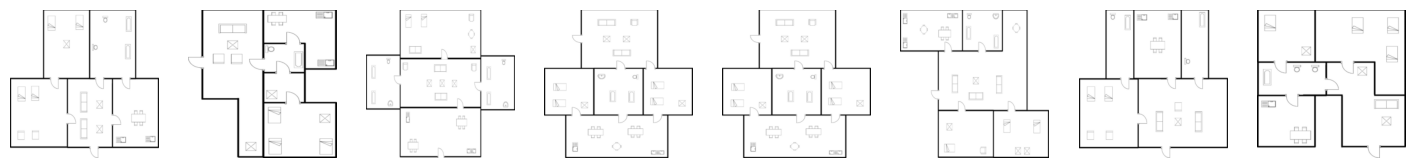

In [15]:
# Visualize a batch of augmented images
def show_batch(dataloader):
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    images = images.numpy()
    fig, axes = plt.subplots(1, 8, figsize=(18, 18))
    for img, ax in zip(images, axes):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.axis('off')
    plt.show()

show_batch(train_loader)

In [16]:
# Define validate_model function
def validate_model(model, val_loader, criterion_gan, criterion_l1, lambda_l1, lambda_kl):
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            generated_images, mu, logvar = model(inputs)
            loss_gan = gan_loss(model.discriminator(generated_images), target_is_real=True)
            loss_l1 = l1_loss(generated_images, targets)
            loss_kl = kl_loss(mu, logvar)
            total_loss = lambda_l1 * loss_l1 + lambda_kl * loss_kl + loss_gan
            total_val_loss += total_loss.item() * inputs.size(0)  # Accumulate loss for the batch
    
    average_val_loss = total_val_loss / len(val_loader.dataset)
    return average_val_loss

# Hyperparameters
lambda_l1 = 15.0  # Weight for L1 loss
lambda_kl = 0.01  # Weight for KL divergence loss

# Training Loop
num_epochs = 50  # Example number of epochs

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        generated_images, mu, logvar = model(inputs)

        # Compute losses
        loss_gan = gan_loss(model.discriminator(generated_images), target_is_real=True)
        loss_l1 = l1_loss(generated_images, targets)
        loss_kl = kl_loss(mu, logvar)

        # Total loss
        total_loss = lambda_l1 * loss_l1 + lambda_kl * loss_kl + loss_gan

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item() * inputs.size(0)  # Accumulate loss for the batch

    # Update learning rate
    scheduler.step()

    # Compute average training loss
    average_train_loss = total_train_loss / len(train_loader.dataset)

    # Compute validation loss
    val_loss = validate_model(model, val_loader, criterion_gan, criterion_l1, lambda_l1, lambda_kl)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save model checkpoint here
    else:
        counter += 1
    
    if counter >= patience:
        print("Early stopping triggered.")
        break


Epoch [1/50], Train Loss: 10.9871, Val Loss: 5.8472
Epoch [2/50], Train Loss: 6.8221, Val Loss: 4.6946
Epoch [3/50], Train Loss: 5.6806, Val Loss: 4.1554
Epoch [4/50], Train Loss: 4.8757, Val Loss: 4.1945
Epoch [5/50], Train Loss: 4.3350, Val Loss: 3.6186
Epoch [6/50], Train Loss: 3.8223, Val Loss: 7.4114
Epoch [7/50], Train Loss: 4.9075, Val Loss: 3.8117
Epoch [8/50], Train Loss: 3.8559, Val Loss: 3.3723
Epoch [9/50], Train Loss: 3.4173, Val Loss: 3.0582
Epoch [10/50], Train Loss: 3.2099, Val Loss: 2.7614
Epoch [11/50], Train Loss: 2.9508, Val Loss: 2.6731
Epoch [12/50], Train Loss: 2.8856, Val Loss: 2.6262
Epoch [13/50], Train Loss: 2.8310, Val Loss: 2.5878
Epoch [14/50], Train Loss: 2.8104, Val Loss: 2.5484
Epoch [15/50], Train Loss: 2.7632, Val Loss: 2.5102
Epoch [16/50], Train Loss: 2.7085, Val Loss: 2.4580
Epoch [17/50], Train Loss: 2.6714, Val Loss: 2.3976
Epoch [18/50], Train Loss: 2.6097, Val Loss: 2.3342
Epoch [19/50], Train Loss: 2.5410, Val Loss: 2.2719
Epoch [20/50], Train

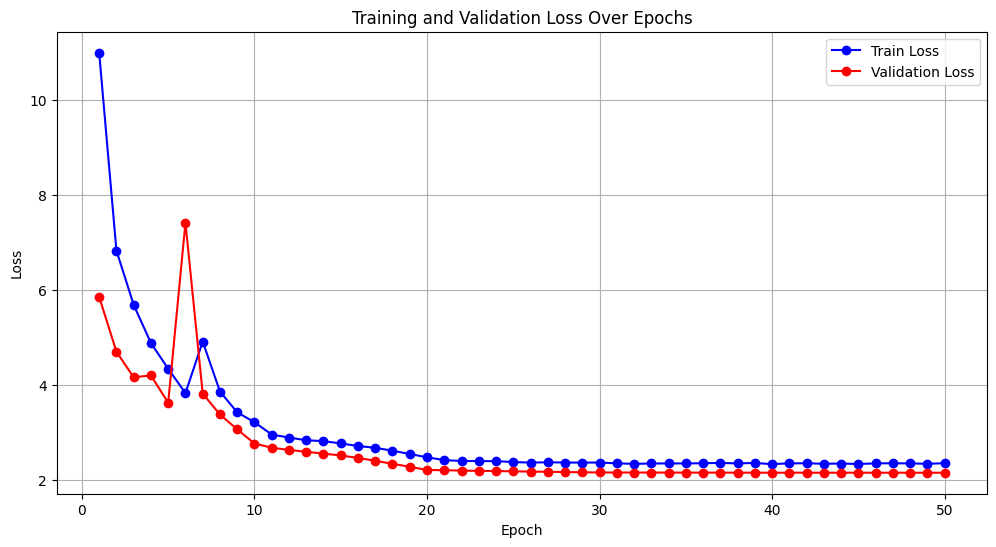

In [20]:
# Define the number of epochs
epochs = list(range(1, 51))  # From 1 to 50

# Updated Training and Validation loss values from your output
train_losses = [10.9871, 6.8221, 5.6806, 4.8757, 4.3350, 3.8223, 4.9075, 3.8559, 3.4173, 3.2099,
                2.9508, 2.8856, 2.8310, 2.8104, 2.7632, 2.7085, 2.6714, 2.6097, 2.5410, 2.4713,
                2.4125, 2.3935, 2.3915, 2.3899, 2.3711, 2.3600, 2.3664, 2.3607, 2.3593, 2.3608,
                2.3441, 2.3328, 2.3409, 2.3421, 2.3415, 2.3459, 2.3523, 2.3430, 2.3520, 2.3267,
                2.3439, 2.3456, 2.3348, 2.3396, 2.3300, 2.3434, 2.3456, 2.3424, 2.3346, 2.3464]

val_losses = [5.8472, 4.6946, 4.1554, 4.1945, 3.6186, 7.4114, 3.8117, 3.3723, 3.0582, 2.7614,
              2.6731, 2.6262, 2.5878, 2.5484, 2.5102, 2.4580, 2.3976, 2.3342, 2.2719, 2.2045,
              2.1993, 2.1917, 2.1857, 2.1809, 2.1759, 2.1701, 2.1655, 2.1610, 2.1557, 2.1513,
              2.1508, 2.1503, 2.1499, 2.1496, 2.1490, 2.1485, 2.1481, 2.1477, 2.1472, 2.1468,
              2.1468, 2.1467, 2.1467, 2.1467, 2.1466, 2.1466, 2.1465, 2.1465, 2.1465, 2.1464]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



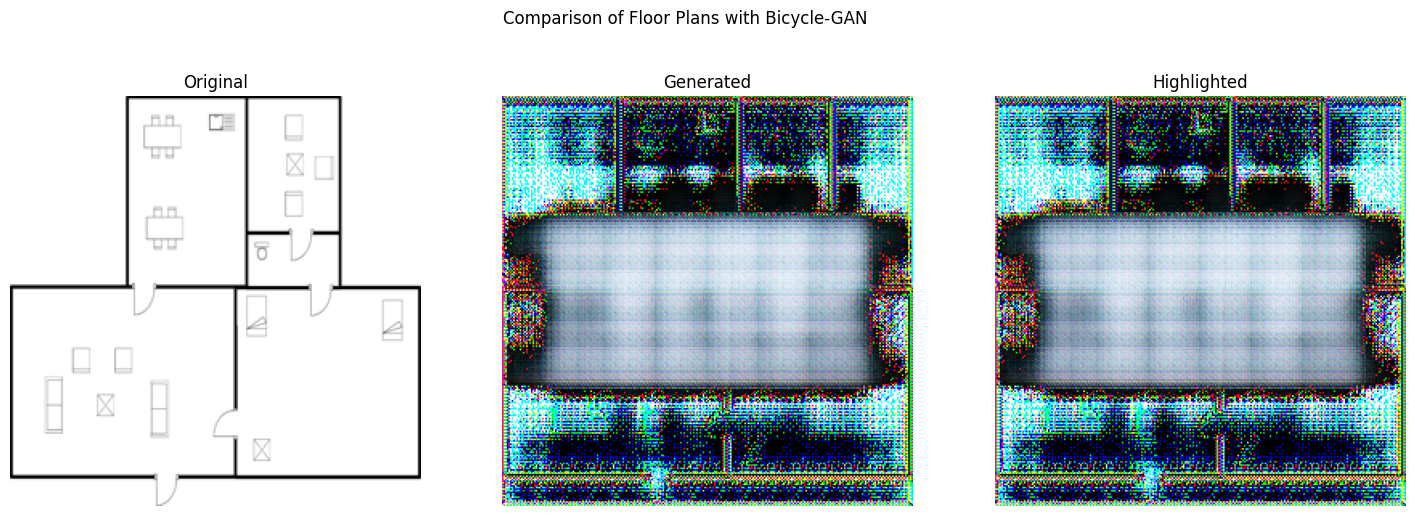

In [17]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2  # OpenCV for color detection and drawing

# Define function to load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Ensure image size matches network input
    image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    return image

# Generate images using the trained model
def generate_image(model, input_image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        generated_images, _, _ = model(input_image)  # Unpack the tuple
        generated_image = generated_images[0].cpu().numpy()  # Remove batch dimension and move to CPU
    generated_image = (generated_image * 255).astype(np.uint8)  # Rescale if needed
    return generated_image

# Define function to draw bounding boxes around detected color regions
def draw_bounding_boxes(image, color):
    # Convert to HWC format for OpenCV
    image_rgb = np.transpose(image, (1, 2, 0))  # Convert to HWC format
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    
    lower_bound = np.array([color[0] - 10, color[1] - 10, color[2] - 10])
    upper_bound = np.array([color[0] + 10, color[1] + 10, color[2] + 10])
    
    mask = cv2.inRange(image_bgr, lower_bound, upper_bound)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_bgr, (x, y), (x+w, y+h), (0, 0, 255), 2)  # Draw bounding boxes in red
    
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Define paths for your images
input_image_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input\Cat45_5.jpg'  # Update with the path to a test image

# Load and preprocess the input image
input_image = preprocess_image(input_image_path)

# Generate an image using the model
generated_image = generate_image(model, input_image)

# Convert the input image to numpy array for plotting
input_image_np = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
input_image_np = (input_image_np * 255).astype(np.uint8)

# Define the color for plant placement (#c1ff72)
plant_color = [193, 255, 114]  # RGB format for #c1ff72

# Draw bounding boxes around plant placement areas
highlighted_generated_image = draw_bounding_boxes(generated_image, plant_color)

# Plot the results
def plot_comparison(original, generated, highlighted_generated, title):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Generated')
    generated_image_to_plot = np.transpose(generated, (1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.imshow(generated_image_to_plot)  # Plot the RGB image

    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Highlighted')
    plt.imshow(highlighted_generated)
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Plot the results
plot_comparison(input_image_np, generated_image, highlighted_generated_image, 'Comparison of Floor Plans with Bicycle-GAN')


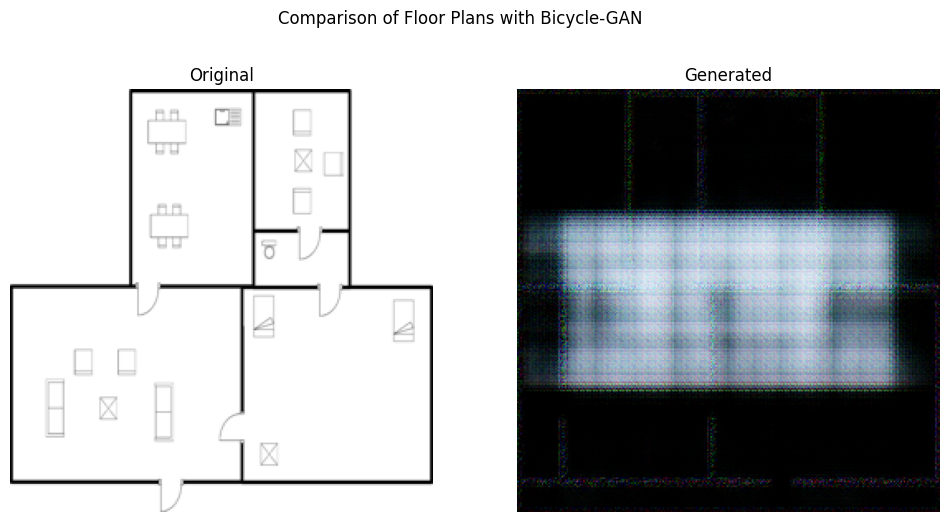

In [18]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Define function to load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Ensure image size matches network input
    image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    return image

def generate_image(model, input_image):
    # ... (existing code)
    generated_image = generated_images[0].detach().cpu().numpy()  # Remove batch dimension and move to CPU
    generated_image = np.transpose(generated_image, (1, 2, 0))  # Convert to HWC format
    generated_image = np.clip(generated_image, 0, 1)  # Ensure values are in [0, 1]
    generated_image = (generated_image * 255).astype(np.uint8)  # Convert to uint8 for display
    return generated_image

# Define paths for your images
input_image_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input\Cat45_5.jpg'  # Update with the path to a test image

# Load and preprocess the input image
input_image = preprocess_image(input_image_path)

# Generate an image using the model
generated_image = generate_image(model, input_image)

# Plot the results
def plot_comparison(original, generated, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original.permute(1, 2, 0).numpy())  # Convert to HWC format for display
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Generated')
    plt.imshow(generated)
    plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Plot the results
plot_comparison(input_image.squeeze(), generated_image, 'Comparison of Floor Plans with Bicycle-GAN')


This is the end of the model training for the second iteration. 